# Biocatalysis Model Retraining

In [114]:
import re
import string
from typing import List
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.axes import Axes

sns.set_theme(context="paper", style="ticks", font="Arial", font_scale=0.5)


## Load Data

### Helper Functions

In [48]:
def get_ec(ec_smiles: str) -> List[str]:
    ec = ec_smiles
    pre_ec_prod = ec_smiles.replace(">>", " ").replace("|", " ").split()

    if ">>" in ec_smiles and "|" in ec_smiles and len(pre_ec_prod) == 3:
        ec = pre_ec_prod[1]
    elif ">>" in ec_smiles:
        ec = "None.None.None"

    return list(ec.split("."))

def load_data(folder: str, set_name: str) -> pd.DataFrame:
    data = { 
        "EC1_GT": [], "EC2_GT": [], "EC3_GT": [], "EC1_PRED": [], 
        "EC2_PRED": [], "EC3_PRED": [], "GROUND_TRUTH": [], "PREDICTION": [], 
        "CORRECT": [], "MODEL": [], "K": [], "SET_NAME": []
    }

    for correct in [True, False]:
        for model in ["bw", "fw", "rtrp"]:
            for k in range(1, 6):
                correct_file_name = "correct" if correct else "incorrect"
                file = Path(folder, f"{correct_file_name}_{model}_{k}.txt")
                    
                with open(file, "r") as f:
                    for line in f:
                        rxn_gt = rxn_pred = ""
                        ec_gt = ec_pred = []

                        if correct:
                            rxn_gt = rxn_pred = line.strip()
                            ec_gt = ec_pred = get_ec(rxn_gt)
                        else:
                            rxn_gt, rxn_pred = line.strip().split(",")
                            ec_gt = get_ec(rxn_gt)
                            ec_pred = get_ec(rxn_pred)
                        
                        data["EC1_GT"].append(ec_gt[0])
                        data["EC2_GT"].append(ec_gt[1])
                        data["EC3_GT"].append(ec_gt[2])
                        data["EC1_PRED"].append(ec_pred[0])
                        data["EC2_PRED"].append(ec_pred[1])
                        data["EC3_PRED"].append(ec_pred[2])
                        data["GROUND_TRUTH"].append(rxn_gt)
                        data["PREDICTION"].append(rxn_pred)
                        data["CORRECT"].append(correct)
                        data["MODEL"].append(model)
                        data["K"].append(k)
                        data["SET_NAME"].append(set_name)
    
    return pd.DataFrame(data)

def load_data_train(src: str, tgt: str, set_name: str) -> pd.DataFrame:
    srcs = [re.sub(r"[vut\[\]]", "", line.strip().replace(" ", "").replace("][", ".")) for line in open(src, "r")]
    tgts = [line.strip().replace(" ", "") for line in open(tgt, "r")]
    data = {"GROUND_TRUTH": [], "EC1_GT": [], "EC2_GT": [], "EC3_GT": [], "SET_NAME": []}

    for s, t in zip(srcs, tgts):
        rxn = f"{s}>>{t}"
        data["GROUND_TRUTH"].append(rxn)
        ec = get_ec(rxn)
        data["EC1_GT"].append(ec[0])
        data["EC2_GT"].append(ec[1])
        data["EC3_GT"].append(ec[2])
        data["SET_NAME"].append(set_name)

    return pd.DataFrame(data)


def index_subplots(
    axs: Axes,
    font_size: float = 20,
    font_weight: str = "bold",
    font_family: str = rcParams["font.family"],
    x: float = -0.1,
    y: float = 1.1,
    uppercase: bool = False,
    prefix: str = "",
    suffix: str = "",
    offset: int = 0,
):
    int_to_char_map = string.ascii_lowercase
    if uppercase:
        int_to_char_map = string.ascii_uppercase

    for i, ax in enumerate(axs):
        ax.text(
            x,
            y,
            prefix + int_to_char_map[i + offset] + suffix,
            transform=ax.transAxes,
            size=font_size,
            weight=font_weight,
            fontfamily=font_family,
        )

### Load the Data using the Helper Functions

In [4]:
df_original = load_data("original", "original")
df_retrained = load_data("retrained/300000", "retrained")
df = pd.concat([df_original, df_retrained])

df_t_original = load_data_train("original/src-train.txt", "original/tgt-train.txt", "original")
df_t_retrained = load_data_train("retrained/src-train.txt", "retrained/tgt-train.txt", "retrained")
df_training = pd.concat([df_t_original, df_t_retrained])

# Remove class 7 as there are only very few examples
df = df[df["EC1_GT"] != "7"]
df_training = df_training[df_training["EC1_GT"] != "7"]

## Process Data

### Training Data

In [5]:
df_t_size = df_training.groupby(
    by=["EC1_GT", "EC2_GT", "EC3_GT", "SET_NAME"]
).size().reset_index().rename(columns={0: "TRAINING_SAMPLE_COUNT"})

df_t_pivot = df_t_size.pivot(index=["EC1_GT", "EC2_GT", "EC3_GT"], columns="SET_NAME").reset_index()
df_t_pivot = df_t_pivot.fillna(0)
df_t_pivot.columns = df_t_pivot.columns.droplevel()
df_t_pivot = df_t_pivot.reset_index()
df_t_pivot.columns = [1, "EC1_GT", "EC2_GT", "EC3_GT", "ORIGINAL", "RETRAINED"]

df_t_pivot = df_t_pivot.sort_values(by="EC1_GT")
df_t_pivot["CHANGE"] = df_t_pivot["RETRAINED"] / df_t_pivot["ORIGINAL"] - 1

df_t_diversity = df_training.drop(columns=["GROUND_TRUTH"]).value_counts().reset_index().rename(columns={0: "COUNT"})
df_t_diversity = df_t_diversity.groupby(by=["EC1_GT", "SET_NAME"]).count().reset_index()

### Prediction Data

In [6]:
df_size = df.groupby(
    by=["EC1_GT", "EC2_GT", "EC3_GT", "MODEL", "K", "CORRECT", "SET_NAME"]
).size().reset_index().rename(columns={0: "COUNT"})


df_pivot = df_size.pivot(index=["EC1_GT", "EC2_GT", "EC3_GT", "SET_NAME", "K", "MODEL"], columns="CORRECT").reset_index()
df_pivot = df_pivot.fillna(0)
df_pivot.columns = df_pivot.columns.droplevel()
df_pivot = df_pivot.reset_index()
df_pivot.columns = [1, "EC1_GT", "EC2_GT", "EC3_GT", "SET_NAME", "K", "MODEL", "N_INCORRECT", "N_CORRECT"]
df_pivot["N_TOTAL"] = df_pivot["N_INCORRECT"] + df_pivot["N_CORRECT"]
df_pivot["ACCURACY"] = df_pivot["N_CORRECT"] / df_pivot["N_TOTAL"]
df_pivot["EC2"] = df_pivot["EC1_GT"] + "." + df_pivot["EC2_GT"]

### Combined Training and Prediction Data

In [7]:
df_joined_size = pd.merge(df_pivot, df_t_size, on=["EC1_GT", "EC2_GT", "EC3_GT", "SET_NAME"], how="left")
df_joined_size = df_joined_size.pivot(
    index=["EC1_GT", "EC2_GT", "EC3_GT", "K", "MODEL"], 
    columns="SET_NAME", values=["ACCURACY", "TRAINING_SAMPLE_COUNT"]
).reset_index()
df_joined_size.columns = df_joined_size.columns.to_series().str.join("_").str.upper().str.strip("_")

df_joined_size["TRAINING_SAMPLE_COUNT_DIFF"] = df_joined_size["TRAINING_SAMPLE_COUNT_RETRAINED"] - df_joined_size["TRAINING_SAMPLE_COUNT_ORIGINAL"]
df_joined_size["ACCURACY_DIFF"] = df_joined_size["ACCURACY_RETRAINED"] - df_joined_size["ACCURACY_ORIGINAL"]

## Visualisations

### Training Data Comparison

<AxesSubplot:xlabel='EC1_GT', ylabel='CHANGE'>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


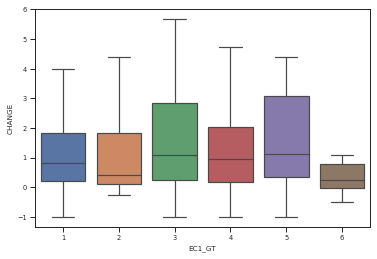

In [8]:
fig, ax = plt.subplots(1, 1)

sns.boxplot(
    data=df_t_pivot, 
    x="EC1_GT", y="CHANGE",
    showfliers=False,
    ax = ax
)

### Performance Comparison

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


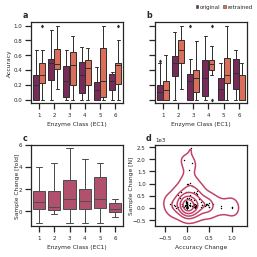

In [115]:
fig, axs = plt.subplots(2, 2, figsize=(3.50394, 3.50394))


df_sub = df_pivot[(df_pivot["K"] == 1) & (df_pivot["N_TOTAL"] <= 999.0) & (df_pivot["N_TOTAL"] > 1.0)]

sns.boxplot(
    x="EC1_GT", y="ACCURACY", 
    hue="SET_NAME", palette="rocket", 
    linewidth=1, fliersize=2.0,
    data=df_sub[df_sub.MODEL == "fw"], 
    ax = axs[0][0]
)
axs[0][0].legend([],[], frameon=False)
axs[0][0].set_ylabel("Accuracy")
axs[0][0].yaxis.labelpad = 1
axs[0][0].set_xlabel("Enzyme Class (EC1)")

sns.boxplot(
    x="EC1_GT", y="ACCURACY", 
    hue="SET_NAME", palette="rocket", 
    linewidth=1, fliersize=2.0,
    data=df_sub[df_sub.MODEL == "bw"], 
    ax = axs[0][1]
)
axs[0][1].legend([],[], frameon=False)
axs[0][1].yaxis.set_ticklabels([])
axs[0][1].set_ylabel("")
axs[0][1].set_xlabel("Enzyme Class (EC1)")

handles, labels = axs[0][1].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='upper right', ncol=2, 
    frameon=False, handlelength=0.5, handletextpad=0.25, columnspacing=0.5
)

sns.boxplot(
    data=df_t_pivot, 
    x="EC1_GT", y="CHANGE",
    showfliers=False,
    color="#c24167",
    linewidth=1,
    ax = axs[1][0]
)
axs[1][0].set_ylabel("Sample Change [fold]")
axs[1][0].yaxis.labelpad = -2
axs[1][0].set_xlabel("Enzyme Class (EC1)")

df_joined_size_subset = df_joined_size[
    (df_joined_size.K == 1) & (df_joined_size.MODEL == "bw") & 
    (df_joined_size.TRAINING_SAMPLE_COUNT_DIFF > 0)
]

sns.kdeplot(
    data=df_joined_size_subset,
    x="ACCURACY_DIFF", 
    y="TRAINING_SAMPLE_COUNT_DIFF",
    levels=6,
    color="#c24167",
    ax=axs[1][1]
)

sns.scatterplot(
    data=df_joined_size_subset,
    x="ACCURACY_DIFF", 
    y="TRAINING_SAMPLE_COUNT_DIFF",
    marker="o",
    color="#000",
    linewidth=0,
    s=2
)

axs[1][1].legend([],[], frameon=False)
axs[1][1].set_ylim((None, 2600))
axs[1][1].set_ylabel("Sample Change [N]")
axs[1][1].yaxis.labelpad = -2
axs[1][1].set_xlabel("Accuracy Change")
axs[1][1].ticklabel_format(style="sci", scilimits=[0,2])

index_subplots(axs.flat, font_size=8, y=1.05)
plt.tight_layout()

plt.savefig("bcm_retraining.svg")
plt.savefig("bcm_retraining.eps")
plt.savefig("bcm_retraining.pdf")

### Performance versus Training Set Size

119


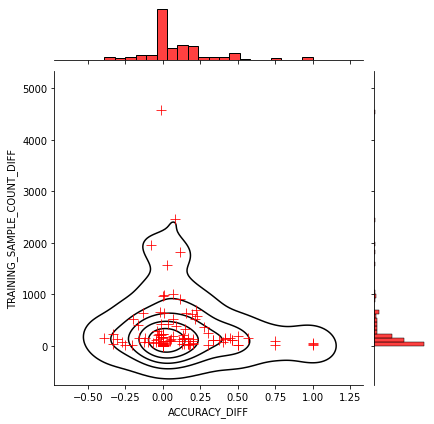

: 

In [216]:
df_joined_size_subset = df_joined_size[
    (df_joined_size.K == 1) & (df_joined_size.MODEL == "bw") & 
    (df_joined_size.TRAINING_SAMPLE_COUNT_DIFF > 0)
]

g = sns.jointplot(
    data=df_joined_size_subset,
    x="ACCURACY_DIFF", 
    y="TRAINING_SAMPLE_COUNT_DIFF",
    color="r",
    marker="+", s=100
)

g.plot_joint(
    sns.kdeplot, color="k", 
    zorder=0, levels=6)